# **Supervised Learning**
---

This notebook implements the full supervised learning pipeline for the **MCF7 cell line**. The aim is to build high-performance binary classifiers that predict the oxygenation condition (normoxia vs hypoxia) of each cell based on gene expression.


For each combination of cell line and technology, we:

- Align metadata and create binary labels from the known condition
- Standardize the expression values (scaling)
- Perform different feature selection strategies tailored to each technology and compare model performance
- Save the best models for test prediction

> We now work with the instructor-provided **filtered and normalized training datasets**. 

> Each step is repeated for both **Smart-seq** and **Drop-seq** datasets, maintaining the same methodology for consistent comparison and integration.

## Index

1. [Load Datasets](#1-load-datasets)  
2. [Align Labels](#2-align-labels)
3. [Preprocessing](#3-preprocessing) 
4. [Feature Selection](#4-feature-selection)  
   - [4.1 SmartSeq](#41-smartseq)
      - [4.1.1 Elastic Net Logistic Regression](#411-elastic-net-logistic-regression)  
      - [4.1.2 Random Forest Importance](#412-random-forest-importance)  
      - [4.1.3 Stability Across Seeds](#413-stability-across-seeds)
   - [4.2 DropSeq](#42-dropseq)
      - [4.2.1 Elastic Net Logistic Regression](#421-elastic-net-logistic-regression) 
      - [4.2.2 Random Forest Importance](#422-random-forest-importance)  
      - [4.2.3 Stability Across Seeds](#423-stability-across-seeds)
5. [Biological Enrichment](#5-biological-enrichment)
   - [5.1 SmartSeq](#51-smartseq)
      - [5.1.1 Over-Representation Analysis (ORA)](#511-over---representation-analysis-ora)
      - [5.1.2 Comparison with Buffa's signature](#512-comparison-with-Buffas-signature)
      - [5.1.3 Expression Patterns of Top Stable Genes](#513-expression-patterns-of-top-stable-genes)
   - [5.2 DropSeq](#52-dropseq)
      - [5.2.1 Over-Representation Analysis](#521-over---representation-analysis)
      - [5.2.2 Comparison with Buffa's signature](#522-comparison-with-Buffas-signature)
      - [5.2.3 Expression Patterns of Top Stable Genes](#523-expression-patterns-of-top-stable-genes)
6. [Model Training and Evaluation](#6-model-training-and-evaluation) 


In [1]:
import os
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pickle
import joblib
from scipy.stats import skew, kurtosis, mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import gseapy as gp
from gseapy.plot import barplot, dotplot
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve)
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from collections import Counter
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from matplotlib_venn import venn2
from pathlib import Path

## **1.** Load Datasets
---

### ***SmartSeq***

We are going to transpose the dataset so that it matches sklearn’s expected input format (n_samples × n_features).

In [2]:
mcf_meta = pd.read_csv("../Data/SmartSeq/MCF7_SmartS_MetaData.tsv", sep="\t", engine= "python", index_col=0)
dfs_mcf_train = pd.read_csv("../Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T
dfs_mcf_train.head()

,CYP1B1,CYP1B1-AS1,CYP1A1,NDRG1,DDIT4,PFKFB3,HK2,AREG,MYBL2,ADM,...,CD27-AS1,DNAI7,MAFG,LZTR1,BCO2,GRIK5,SLC25A27,DENND5A,CDK5R1,FAM13A-AS1
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord.out.bam,343,140,0,0,386,75,0,0,476,0,...,63,0,17,59,0,0,0,51,0,0
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord.out.bam,131,59,0,1,289,42,0,856,1586,0,...,0,0,1,25,0,0,0,34,0,0
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord.out.bam,452,203,0,0,0,0,0,0,775,0,...,15,0,23,0,0,0,0,0,0,0
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord.out.bam,27,7,0,0,288,214,15,242,1191,0,...,1,0,3,10,0,0,0,4,0,0
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord.out.bam,5817,2669,0,654,2484,1603,748,436,0,0,...,0,0,63,0,0,0,0,60,0,0


In [3]:
print(dfs_mcf_train.isnull().sum())

CYP1B1        0
CYP1B1-AS1    0
CYP1A1        0
NDRG1         0
DDIT4         0
             ..
GRIK5         0
SLC25A27      0
DENND5A       0
CDK5R1        0
FAM13A-AS1    0
Length: 3000, dtype: int64


In [4]:
dfs_mcf_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord.out.bam to output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam
Columns: 3000 entries, CYP1B1 to FAM13A-AS1
dtypes: int64(3000)
memory usage: 5.7+ MB


#### - *Check Duplicates*

In [5]:
def find_duplicates(dataframe):
    dupes = []
    columns = dataframe.columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            if dataframe[columns[i]].equals(dataframe[columns[j]]):
                dupes.append((columns[i], columns[j]))
    return dupes

In [6]:
duplicate_genes = find_duplicates(dfs_mcf_train)
print("Duplicated genes (identical content):")
print(duplicate_genes if duplicate_genes else "None found")

Duplicated genes (identical content):
[('UGT1A8', 'UGT1A9')]


In [7]:
duplicate_cells = find_duplicates(dfs_mcf_train.T)
print("Duplicated cells (identical content):")
print(duplicate_cells if duplicate_cells else "None found")

Duplicated cells (identical content):
None found


In [8]:
dfs_mcf_train = dfs_mcf_train.drop("UGT1A9", axis=1)

#### - *Check Distribution*

In [9]:
print("Summary statistics:")
display(dfs_mcf_train.describe())

Summary statistics:


,CYP1B1,CYP1B1-AS1,CYP1A1,NDRG1,DDIT4,PFKFB3,HK2,AREG,MYBL2,ADM,...,CD27-AS1,DNAI7,MAFG,LZTR1,BCO2,GRIK5,SLC25A27,DENND5A,CDK5R1,FAM13A-AS1
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,5454.536000,2258.572000,1604.580000,606.380000,2487.000000,1495.920000,868.424000,308.984000,394.988000,183.096000,...,22.036000,0.192000,50.884000,23.308000,0.192000,0.256000,0.160000,60.536000,2.860000,5.952000
std,8282.337795,3453.650882,5657.397449,766.718881,3422.213185,2109.376474,1837.399974,592.950034,564.259514,470.374582,...,43.250493,2.000787,69.729761,36.415015,1.309195,2.001622,1.167842,75.647093,8.839056,21.649028
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,200.750000,85.000000,0.000000,1.000000,96.000000,71.000000,8.250000,0.000000,0.000000,0.000000,...,0.000000,0.000000,13.250000,0.000000,0.000000,0.000000,0.000000,11.250000,0.000000,0.000000
50%,795.000000,321.500000,0.000000,222.500000,1198.500000,369.500000,139.500000,18.000000,123.500000,0.000000,...,8.000000,0.000000,37.000000,1.000000,0.000000,0.000000,0.000000,38.500000,0.000000,0.000000
75%,8180.500000,3348.500000,284.500000,1077.500000,3720.000000,2180.750000,1008.000000,371.000000,629.000000,74.500000,...,30.000000,0.000000,63.000000,41.000000,0.000000,0.000000,0.000000,77.000000,0.000000,0.000000
max,44406.000000,17673.000000,58717.000000,3884.000000,21994.000000,12078.000000,16625.000000,3496.000000,3108.000000,3586.000000,...,509.000000,28.000000,816.000000,196.000000,14.000000,26.000000,11.000000,639.000000,62.000000,288.000000


### ***DropSeq***

In [10]:
dfd_mcf_train = pd.read_csv("../Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt", sep=r"\s+", engine= "python", index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"')).T
print(dfd_mcf_train.shape)

(21626, 3000)


In [11]:
print(dfd_mcf_train.isnull().sum())

MALAT1       0
MT-RNR2      0
NEAT1        0
H1-5         0
TFF1         0
            ..
BRWD1-AS2    0
RPS19BP1     0
AUNIP        0
TNK2         0
SUDS3        0
Length: 3000, dtype: int64


In [12]:
dfd_mcf_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21626 entries, AAAAACCTATCG_Normoxia to TTTTTTGTATGT_Hypoxia
Columns: 3000 entries, MALAT1 to SUDS3
dtypes: int64(3000)
memory usage: 495.1+ MB


#### - *Check Duplicates*

In [70]:
duplicate_genes = find_duplicates(dfd_mcf_train)
print("Duplicated genes (identical content):")
print(duplicate_genes if duplicate_genes else "None found")

Duplicated genes (identical content):
None found


In [14]:
duplicate_cells = find_duplicates(dfs_mcf_train.T)
print("Duplicated cells (identical content):")
print(duplicate_cells if duplicate_cells else "None found")

Duplicated cells (identical content):
None found


#### - *Check Distribution*

In [15]:
print("Summary statistics:")
display(dfs_mcf_train.describe())

Summary statistics:


,CYP1B1,CYP1B1-AS1,CYP1A1,NDRG1,DDIT4,PFKFB3,HK2,AREG,MYBL2,ADM,...,CD27-AS1,DNAI7,MAFG,LZTR1,BCO2,GRIK5,SLC25A27,DENND5A,CDK5R1,FAM13A-AS1
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,5454.536000,2258.572000,1604.580000,606.380000,2487.000000,1495.920000,868.424000,308.984000,394.988000,183.096000,...,22.036000,0.192000,50.884000,23.308000,0.192000,0.256000,0.160000,60.536000,2.860000,5.952000
std,8282.337795,3453.650882,5657.397449,766.718881,3422.213185,2109.376474,1837.399974,592.950034,564.259514,470.374582,...,43.250493,2.000787,69.729761,36.415015,1.309195,2.001622,1.167842,75.647093,8.839056,21.649028
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,200.750000,85.000000,0.000000,1.000000,96.000000,71.000000,8.250000,0.000000,0.000000,0.000000,...,0.000000,0.000000,13.250000,0.000000,0.000000,0.000000,0.000000,11.250000,0.000000,0.000000
50%,795.000000,321.500000,0.000000,222.500000,1198.500000,369.500000,139.500000,18.000000,123.500000,0.000000,...,8.000000,0.000000,37.000000,1.000000,0.000000,0.000000,0.000000,38.500000,0.000000,0.000000
75%,8180.500000,3348.500000,284.500000,1077.500000,3720.000000,2180.750000,1008.000000,371.000000,629.000000,74.500000,...,30.000000,0.000000,63.000000,41.000000,0.000000,0.000000,0.000000,77.000000,0.000000,0.000000
max,44406.000000,17673.000000,58717.000000,3884.000000,21994.000000,12078.000000,16625.000000,3496.000000,3108.000000,3586.000000,...,509.000000,28.000000,816.000000,196.000000,14.000000,26.000000,11.000000,639.000000,62.000000,288.000000


## **2.** Align Labels
---

### ***SmartSeq***

In [16]:
X_mcf_smart = dfs_mcf_train
X_mcf_smart.head()

,CYP1B1,CYP1B1-AS1,CYP1A1,NDRG1,DDIT4,PFKFB3,HK2,AREG,MYBL2,ADM,...,CD27-AS1,DNAI7,MAFG,LZTR1,BCO2,GRIK5,SLC25A27,DENND5A,CDK5R1,FAM13A-AS1
output.STAR.2_B3_Norm_S57_Aligned.sortedByCoord.out.bam,343,140,0,0,386,75,0,0,476,0,...,63,0,17,59,0,0,0,51,0,0
output.STAR.2_B4_Norm_S58_Aligned.sortedByCoord.out.bam,131,59,0,1,289,42,0,856,1586,0,...,0,0,1,25,0,0,0,34,0,0
output.STAR.2_B5_Norm_S59_Aligned.sortedByCoord.out.bam,452,203,0,0,0,0,0,0,775,0,...,15,0,23,0,0,0,0,0,0,0
output.STAR.2_B6_Norm_S60_Aligned.sortedByCoord.out.bam,27,7,0,0,288,214,15,242,1191,0,...,1,0,3,10,0,0,0,4,0,0
output.STAR.2_B7_Hypo_S79_Aligned.sortedByCoord.out.bam,5817,2669,0,654,2484,1603,748,436,0,0,...,0,0,63,0,0,0,0,60,0,0


In [17]:
print(mcf_meta["Condition"].value_counts())

Condition
Norm    192
Hypo    191
Name: count, dtype: int64


In [18]:
mcf_meta["Label"] = mcf_meta["Condition"].map({"Norm": 0, "Hypo": 1})
print(mcf_meta["Label"].value_counts())

Label
0    192
1    191
Name: count, dtype: int64


In [19]:
mcf_meta = mcf_meta.loc[X_mcf_smart.index]
assert all(X_mcf_smart.index == mcf_meta.index), "Index mismatch!"

X_mcfs_merged = X_mcf_smart.copy()
X_mcfs_merged["Label"] = mcf_meta["Label"]

y_mcf_smart = mcf_meta["Label"].values

In [20]:
print(X_mcf_smart.shape)
print(y_mcf_smart.shape)
print("Normoxic:", sum(y_mcf_smart == 0))
print("Hypoxic :", sum(y_mcf_smart == 1))

(250, 2999)
(250,)
Normoxic: 126
Hypoxic : 124


### ***DropSeq***

In [21]:
X_mcf_drop = dfd_mcf_train
X_mcf_drop.head()

,MALAT1,MT-RNR2,NEAT1,H1-5,TFF1,MT-RNR1,H4C3,GDF15,KRT81,MT-CO3,...,MROH1,SKIDA1,MICALL1,RARG,MYO1F,BRWD1-AS2,RPS19BP1,AUNIP,TNK2,SUDS3
AAAAACCTATCG_Normoxia,1,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACAACCCTA_Normoxia,3,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACACTCTCA_Normoxia,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACCAGGCAC_Normoxia,6,2,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACCTAGCTC_Normoxia,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [22]:
labels = X_mcf_drop.index.str.split("_").str[-1]

In [23]:
labels = labels.map({'Normoxia': 0, 'Hypoxia': 1})

In [24]:
print("Label distribution:")
print(labels.value_counts(dropna=False))

Label distribution:
0    12705
1     8921
Name: count, dtype: int64


In [25]:
X_mcfd_merged = X_mcf_drop.copy()
X_mcfd_merged["Label"] = labels
y_mcf_drop = labels.values

In [26]:
print(X_mcf_drop.shape)
print(y_mcf_drop.shape)
print("Normoxic:", sum(y_mcf_drop == 0))
print("Hypoxic :", sum(y_mcf_drop == 1))

(21626, 3000)
(21626,)
Normoxic: 12705
Hypoxic : 8921


## **3.** Preprocessing
---

### ***SmartSeq***

The first step is a train-validation split using stratified sampling to preserve the proportion of hypoxic and normoxic cells in both subsets. The held out testing subset will be used only for evaluation purposes.

In [27]:
# Splitting with stratification
Xs_train, Xs_val, ys_train, ys_val = train_test_split(
    X_mcf_smart, y_mcf_smart, test_size=0.2, stratify=y_mcf_smart, random_state=42
)

Then we apply a log-transformation which compress the right‐hand tail of the distribution. It is a $ \log(1p) $ transformation which converts each raw value $x$ into $\log(1+x)$, preserving 0s.

In [28]:
Xs_train_log = np.log1p(Xs_train)
Xs_val_log = np.log1p(Xs_val)

Then we create a standardized (Z-Score) version of the data, that will be needed for distance-based classifiers, which are sensible to scale.

In [29]:
# Standardize on the log-transformed data
scaler = StandardScaler()
Xs_train_scaled = scaler.fit_transform(Xs_train_log)
Xs_val_scaled = scaler.transform(Xs_val_log)

In [30]:
Xs_train_scaled_df = pd.DataFrame(Xs_train_scaled, columns=Xs_train.columns, index=Xs_train.index)
Xs_val_scaled_df = pd.DataFrame(Xs_val_scaled, columns=Xs_val.columns, index=Xs_val.index)

### **DropSeq**

In [31]:
Xd_train, Xd_val, yd_train, yd_val = train_test_split(
    X_mcf_drop, y_mcf_drop, test_size=0.2, stratify=y_mcf_drop, random_state=42
)

Since the DropSeq dataset is way larger than SmartSeq's one, we apply a pre-filter startegy to reduce dimensionality from 3000 genes to 300 by **Mutual Information**.  
This allows us to identify genes that are most informative about the target labels.

In [32]:
#Mutual Information (only on train set)
k_top_genes = 300
mi_selector = SelectKBest(score_func=mutual_info_classif, k=k_top_genes)
X_train_mi = mi_selector.fit_transform(Xd_train, yd_train)

selected_mi_genes = Xd_train.columns[mi_selector.get_support()]
print("Shape after filtering:", X_train_mi.shape)

Shape after filtering: (17300, 300)


In [33]:
# Extract only the 300 MI-selected genes
Xd_train_mi = Xd_train[selected_mi_genes]
Xd_val_mi   = Xd_val[selected_mi_genes]

Now we can proceed with the log-stransformation and the standardization (Z-score).

In [34]:
# Log-transform
Xd_train_log = np.log1p(Xd_train_mi)
Xd_val_log   = np.log1p(Xd_val_mi)

In [35]:
# Standardization
scaler = StandardScaler()
Xd_train_scaled = scaler.fit_transform(Xd_train_log)
Xd_val_scaled   = scaler.transform(Xd_val_log)

## **4.** Feature Selection
---

This section aims to reduce the number of genes to mitigate overfitting, enhance interpretability, and improve generalization performance.

We leverage **embedded methods** that exploit the learning algorithm to automatically rank and select features. The pipeline consists of:

1. **Elastic Net logistic regression**  
   - Perform an inner 5-fold `GridSearchCV` over the regularization strength (`C`) and mixing parameter (`l1_ratio`) using the `saga` solver.  
   - Fit the best model on each training split and select genes with non-zero coefficients.

2. **Random Forest ranking**  
   - Tune `n_estimators`, `max_depth`, and `min_samples_leaf` via grid search on the same training splits.  
   - Rank genes by `feature_importances_` and retain the top 20 per seed.

3. **Stability analysis across seeds**  
   - Repeat steps 1–2 over 5 different random seeds.  
   - Define a gene as **stable** if it appears in all Elastic Net selections **and** in ≥ 2/5 RF top-20 lists.

4. **Final signature**  
   - Take the intersection of the stable Elastic Net and RF gene sets to form the robust, predictive signature.

### **4.1.** ***SmartSeq***
In this section, we perform feature selection on the Smart-seq dataset, which consists of 3000 pre-filtered genes measured across 250 single cells.

### **4.1.1.** Elastic Net Logistic Regression
To reduce dimensionality and improve both predictive performance and interpretability, we use **Elastic Net**–regularized logistic regression. Elastic Net combines L₁ (Lasso) and L₂ (Ridge) penalties, which

- **Promotes sparsity** through the L₁ term, zeroing out uninformative gene coefficients  
- **Groups correlated features** via the L₂ term, yielding more stable and biologically coherent signatures   

**Implementation details**  
1. **Pipeline**  
   - `StandardScaler()` → `LogisticRegression(penalty='elasticnet', solver='saga')`  
2. **Hyperparameter tuning**  
   - Wrap the pipeline in `GridSearchCV` with 5-fold CV (scoring=`roc_auc`)  
   - Tune  
     - **`clf__C`** ∈ [0.01, 0.1, 1, 10] (inverse regularization strength)  
     - **`clf__l1_ratio`** ∈ [0.1, 0.5, 0.9] (L₁ vs. L₂ mix)  
3. **Feature selection**  
   - After grid search, fit the best model on each training fold  
   - **Select genes** whose coefficients `coef_` ≠ 0  

This embedded selection step yields a sparse, interpretable set of genes that capture the strongest signals distinguishing normoxia from hypoxia, while mitigating instability in the presence of co-expressed gene modules.


In [36]:
# Train LASSO with internal CV
elastic_net = LogisticRegressionCV(
    Cs=20,                   # 20 inverse‐regularization values
    cv=5,                    # 5‐fold internal CV
    penalty='elasticnet',    
    solver='saga',            
    l1_ratios=[0.1, 0.5, 0.9], # sweep over α = 0.1, 0.5, 0.9
    scoring='roc_auc',        # use AUC for model selection
    max_iter=10000,
    random_state=42,
    n_jobs=-1
)
elastic_net.fit(Xs_train_scaled, ys_train)

best_C = elastic_net.C_[0]
best_l1 = elastic_net.l1_ratio_[0]
print(f"Best C: {best_C:.4f}")
print(f"Best l1_ratio: {best_l1:.2f}")

# Extract selected genes
selector = SelectFromModel(elastic_net, prefit=True)
selected_mask = selector.get_support()
elastic_net_genes = Xs_train.columns[selected_mask]

print(f"Selected {len(elastic_net_genes)} genes from full training set using Elastic Net.")

Best C: 0.0018
Best l1_ratio: 0.10
Selected 64 genes from full training set using Elastic Net.


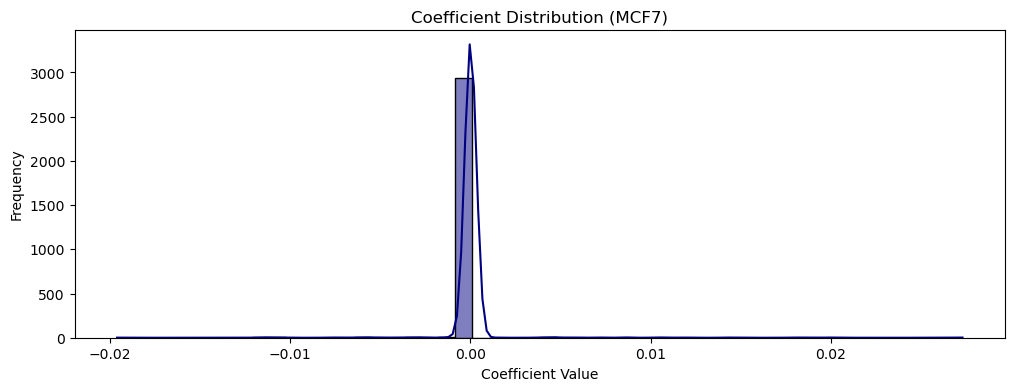

In [37]:
plt.figure(figsize=(12, 4))
sns.histplot(elastic_net.coef_.flatten(), bins=50, color='navy', kde=True)
plt.title("Coefficient Distribution (MCF7)")
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.show()

In [38]:
selected_genes = Xs_train.columns[selected_mask]
print("Selected genes:", selected_genes.tolist())

Selected genes: ['CYP1B1', 'CYP1B1-AS1', 'NDRG1', 'DDIT4', 'PFKFB3', 'HK2', 'VEGFA', 'BNIP3', 'SLC2A1', 'PFKFB4', 'ASF1B', 'HILPDA', 'UHRF1', 'ENO2', 'KDM3A', 'MT-CYB', 'SLC9A3R1', 'RECQL4', 'SFXN2', 'UBC', 'MT-CO3', 'GPI', 'PGK1', 'LDHA', 'IFITM3', 'ERO1A', 'DSP', 'IRF2BP2', 'TUBG1', 'MT-ATP6', 'FUT11', 'IFITM1', 'P4HA1', 'FAM162A', 'PDK1', 'SLC27A4', 'RIMKLA', 'SLC29A1', 'BNIP3L', 'MOV10', 'HLA-C', 'IFITM2', 'ELOVL2', 'ELOVL5', 'ACTG1', 'PYCR3', 'MFSD3', 'PFKP', 'GAPDH', 'HNRNPA2B1', 'FDPS', 'TST', 'CRELD2', 'MT-ATP8', 'IL27RA', 'PSME2', 'SNRNP25', 'HLA-B', 'SLC9A3R1-AS1', 'MTATP6P1', 'NECAB1', 'NME1-NME2', 'ALDOA', 'PCLAF']


### **4.1.2.** Random Forest Importance

To capture non-linear gene–gene interactions and complement the linear Elastic Net selection, we apply a **Random Forest** classifier:

1. **Pipeline**  
   - Use `RandomForestClassifier()` (trees handle unscaled features directly).

2. **Hyperparameter tuning**  
   - Wrap the pipeline in `GridSearchCV` with 5-fold CV (scoring=`roc_auc`).  
   - Tune key parameters:  
     - **`n_estimators`** ∈ [100, 400, 600, 1000]  
     - **`max_depth`** ∈ [None, 10, 20]  
     - **`min_samples_leaf`** ∈ [1, 5]  

3. **Feature importance**  
   - Fit the best estimator on each training fold.  
   - Rank genes by `feature_importances_`.  
   - **Select the top 20 genes** per seed for downstream stability analysis.

This non-linear ranking allows us to:
- Verify which genes are important beyond the Elastic Net selection  
- Ensure that high cross-validated performance is not driven solely by linear effects  
- Provide a complementary perspective on gene relevance in the hypoxia vs. normoxia classification task  


In [39]:
param_grid = {
  'n_estimators': [100, 400, 600, 1000],
  'max_depth': [None, 10, 20],
  'min_samples_leaf': [1, 5]
}
rf = RandomForestClassifier(random_state=0)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,                    # small inner CV on the training split
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid.fit(Xs_train_log, ys_train)

print("Best RF params:", grid.best_params_)
print("CV AUC:", grid.best_score_)

rf.fit(Xs_train_log, ys_train)

# Evaluate AUC on val
ys_val_proba_rf = rf.predict_proba(Xs_val_log)[:, 1]
auc_rf = roc_auc_score(ys_val, ys_val_proba_rf)
print(f"RF ROC AUC on val (full genes): {auc_rf:.4f}")

# Compute importances only for LASSO-selected genes
importances = rf.feature_importances_
gene_names = np.array(Xs_train.columns)
top_indices = np.argsort(importances)[::-1][:20]
top_rf_genes = gene_names[top_indices]

print("Top 20 RF genes:")
for g in top_rf_genes[:20]:
    print(g)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
CV AUC: 1.0
RF ROC AUC on val (full genes): 1.0000
Top 20 RF genes:
HK2
MT-ATP8
PDK1
FDPS
BNIP3
NDRG1
MT-CO3
MT-CYB
GPI
TUBG1
FASN
UBC
MT-ATP6
DDIT4
TES
LDHA
FDFT1
P4HA1
BNIP3L
SDF2L1


### **4.1.3.** Stability Across Seeds
Embedded selection methods can be sensitive to random initialization and the particular train–validation split. To ensure our final gene signature is **robust** and **reproducible**, we repeat the Elastic Net + Random Forest pipeline over multiple random seeds.  

For each `seed`:
   - **Train–validation split**: stratified 80/20 split with `random_state=seed`.  
   - **Elastic Net**: fit the tuned model (`C=best_C`, `l1_ratio=best_l1_ratio`) on the scaled train fold → select non-zero genes.  
   - **Random Forest**: fit the tuned RF (`n_estimators`, `max_depth`, `min_samples_leaf` from grid search) on the log-transformed train fold → pick top 20 genes by `feature_importances_`.

This approach filters out genes that appear spuriously due to a particular split or random seed, enhancing reproducibility and ensuring that our downstream biological interpretations rest on a stable foundation.

In [40]:
best_C = elastic_net.C_[0]
best_l1_ratio = elastic_net.l1_ratio_[0]
rf_params = grid.best_params_
seeds = [7, 21, 42, 123, 999]

en_sets = []
rf_sets = []

for seed in seeds:
    print(f"\n Seed {seed}")

    # Stratified train/val split
    X_train, _, y_train, _ = train_test_split(
        Xs_train, ys_train, test_size=0.2,
        stratify=ys_train, random_state=seed
    )
    #Normalize
    X_train_log = np.log1p(X_train)

    # Scaling on training set only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_log)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

    # Elastic Net
    en = LogisticRegression(
        penalty='elasticnet', solver='saga',
        C=best_C, l1_ratio=best_l1_ratio,
        max_iter=10000, random_state=seed, n_jobs=-1
    )
    en.fit(X_train_scaled, y_train)

    # Select non-zero genes
    selector = SelectFromModel(en, prefit=True)
    selected_en = X_train.columns[selector.get_support()]
    en_sets.append(set(selected_en))

    # RF for nonlinear ranking (Log Only)
    rf = RandomForestClassifier(
        n_estimators=rf_params['n_estimators'],
        max_depth=rf_params['max_depth'],
        min_samples_leaf=rf_params['min_samples_leaf'],
        random_state=seed, n_jobs=-1
    )
    rf.fit(X_train_log, y_train)
    importances = rf.feature_importances_
    top_rf_genes_smart = X_train.columns[np.argsort(importances)[-20:]]
    rf_sets.append(set(top_rf_genes_smart))
    print(f"Top RF genes (sample): {list(top_rf_genes_smart)[:5]}")


 Seed 7
Top RF genes (sample): ['PSME2', 'VEGFA', 'MTATP6P1', 'PFKP', 'BNIP3L']

 Seed 21
Top RF genes (sample): ['GAPDH', 'FDFT1', 'MT-ATP6', 'DSP', 'IFITM3']

 Seed 42
Top RF genes (sample): ['SDF2L1', 'FASN', 'SLC2A1', 'PGP', 'ALDOA']

 Seed 123
Top RF genes (sample): ['ITGA5', 'HK2', 'MT-ATP6', 'FDPS', 'ACTG1']

 Seed 999
Top RF genes (sample): ['P4HA1', 'SLC25A39', 'GPI', 'ACTG1', 'MT-ATP8']


In [41]:
en_counter_smart = Counter(g for s in en_sets for g in s)
rf_counter_smart = Counter(g for s in rf_sets for g in s)

stable_genes_smart = [g for g,c in en_counter_smart.items() if c >= 5 and rf_counter_smart[g] >= 2]
print(f"\nFinal stable genes ({len(stable_genes_smart)}):\n{stable_genes_smart}")


Final stable genes (18):
['DSP', 'MT-ATP8', 'PFKP', 'IFITM2', 'VEGFA', 'MT-ATP6', 'P4HA1', 'MTATP6P1', 'MT-CYB', 'FAM162A', 'HK2', 'ENO2', 'NDRG1', 'MT-CO3', 'GAPDH', 'BNIP3', 'ALDOA', 'GPI']


In [42]:
# Save as txt file
with open("stable_genes_mcf_smart.txt", "w") as f:
    for g in stable_genes_smart:
        f.write(g + "\n")

### **4.2.** ***DropSeq***  
This section performs feature selection on the Drop-seq dataset, which consists of the 300 pre-filtered genes and about $\sim$ 17000 cells.


### **4.2.1.** Elastic Net Logistic Regression  
After MI filtering, we
1. **Apply Elastic Net logistic regression** (embedded selection)  
2. **Tune** both the inverse‐regularization strength `C` and the elastic‐net mix `l1_ratio` via 5-fold `GridSearchCV` (scoring=`roc_auc`)  
3. **Extract** top genes  

This combination of sparsity (L₁) and grouping (L₂) penalties helps guard against noisy, correlated predictors while ensuring we capture the strongest, most reproducible signals.

In [43]:
pipe_en = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=10000,
        random_state=42
    ))
])

# 2) Define hyperparameter grid
param_grid = {
    'clf__C':        [0.0005, 0.001, 0.005, 0.01, 0.05],
    'clf__l1_ratio': [0.1, 0.5, 0.9]
}

# 3) GridSearchCV on Drop-seq training data
search = GridSearchCV(
    pipe_en,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
search.fit(Xd_train_log, yd_train)   # Xd_train: cells×300 genes, yd_train: labels

best_model = search.best_estimator_
# Extract scaled training data (pipeline includes StandardScaler)
X_scaled = best_model.named_steps['scaler'].transform(Xd_train_log)

# Get coefficient array from the LogisticRegression step
coefs = best_model.named_steps['clf'].coef_.ravel()

# Build a boolean mask of which coefficients are nonzero
selected_mask = np.abs(coefs) > 1e-8

# Subset the gene names and the data
selected_genes = list(Xd_train_log.columns[selected_mask])
X_selected = Xd_train_log.loc[:, selected_mask]

# Output results
print("Best hyperparameters:", search.best_params_)
print(f"Number of genes retained by Elastic Net: {len(selected_genes)}")
print("Shape of selected feature matrix:", X_selected.shape)
print("Selected genes:", selected_genes)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best hyperparameters: {'clf__C': 0.05, 'clf__l1_ratio': 0.5}
Number of genes retained by Elastic Net: 233
Shape of selected feature matrix: (17300, 233)
Selected genes: ['MALAT1', 'MT-RNR2', 'TFF1', 'MT-RNR1', 'H4C3', 'MT-CO3', 'MT-ND4', 'MT-ND3', 'MT-CYB', 'TMSB10', 'MT-ATP6', 'MT-CO2', 'MT-TS1', 'MT-ND6', 'MT-CO1', 'MT-ND2', 'MTND1P23', 'MT-ND4L', 'MT-ND5', 'MT-ND1', 'BCYRN1', 'MT-TA', 'RPS5', 'MT-TQ', 'HES1', 'LGALS1', 'TMEM64', 'MT-TE', 'RPL12', 'MUC5B', 'H1-2', 'TOB1', 'RPL39', 'ANKRD52', 'MT-TD', 'RPS16', 'GPM6A', 'ATP1A1', 'TFF3', 'IRF7', 'FGF23', 'CSK', 'ZNF441', 'CLCN7', 'PLBD2', 'NEB', 'RPL35', 'GOLGA4', 'TMEM191C', 'PTP4A2', 'CARD10', 'HNRNPA2B1', 'SOX4', 'RPS19', 'HNRNPAB', 'LINC02913', 'RPLP2', 'RPL36', 'PARD6B', 'TSHZ2', 'ZNF2', 'RPL13', 'TPI1', 'SKI', 'NCL', 'S100A10', 'PURPL', 'CAPZA1', 'FTL', 'HCN2', 'CERS2', 'RPL35A', 'ENO1', 'NIN', 'RHOD', 'KRT19', 'RPS14', 'RPL34', 'FAM102A', 'DSP', 'UQCRQ', 'CAMTA2', 'KCN

### **4.2.2** Random Forest Validation  
To validate the informativeness of the selected genes, we train a **Random Forest classifier** on the top MI-filtered genes.

This non-linear ensemble method provides an alternative perspective on gene importance, complementary to Elastic Net.  
We extract the top genes by importance score.

This step ensures that the selected features are not only sparse but also robust across model types.


In [44]:
# Random Forest validation on selected genes
pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'clf__n_estimators':    [100, 400, 600, 1000],
    'clf__max_depth':       [None, 10, 20],
    'clf__min_samples_leaf':[1, 5]
}
search_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
search_rf.fit(Xd_train_log, yd_train)

best_rf = search_rf.best_estimator_
print("Best RF params:", search_rf.best_params_)

# Feature importances
importances = best_rf.named_steps['clf'].feature_importances_
gene_names = np.array(selected_mi_genes)
top_rf_indices = np.argsort(importances)[::-1][:20]

print("Top 20 genes by RF importance:")
for i in top_rf_indices:
    print(f"{gene_names[i]}: {importances[i]:.5f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/opt/anaconda3/envs/ai_lab/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 600}
Top 20 genes by RF importance:
TFF1: 0.07157
MT-RNR2: 0.06170
GAPDH: 0.04395
KRT19: 0.04334
TMSB10: 0.04295
LGALS1: 0.04279
PGK1: 0.03863
RPL13: 0.02844
RPS19: 0.02783
MT-RNR1: 0.02781
RPS14: 0.02457
TPI1: 0.02335
ENO1: 0.02074
RPL35: 0.01733
PKM: 0.01675
RPL15: 0.01491
RPL34: 0.01383
RPL12: 0.01297
BCYRN1: 0.01288
MALAT1: 0.01088


### **4.2.3.** Stability Analysis Across Seeds  
To ensure robustness, we repeat Elastic Net and Random Forest selection across multiple random seeds.  

For each seed, we extract the top genes selected by each method. Then, we count how often each gene is selected across runs.  
This allows us to identify **stable genes** that consistently appear regardless of random initialization — a proxy for reliability.


In [45]:
X_train_mi_df = pd.DataFrame(Xd_train_scaled, columns=selected_mi_genes, index=Xd_train.index)

seeds = [7, 21, 42, 123, 999]
drop_en_sets = []
drop_rf_sets = []

for seed in seeds:
    # 1) Stratified split on MI-filtered features
    X_tr_mi, _, y_tr, _ = train_test_split(
        X_train_mi_df, yd_train, 
        test_size=0.2, stratify=yd_train, random_state=seed
    )
    # Corresponding log data for RF (same train indices)
    train_idx = X_tr_mi.index
    X_tr_log = Xd_train_log.loc[train_idx, selected_mi_genes]
    
    # 2) Elastic Net selection
    en = LogisticRegression(
        penalty='elasticnet', solver='saga',
        C=best_C, l1_ratio=best_l1_ratio,
        max_iter=10000, random_state=seed, n_jobs=-1
    )
    en.fit(X_tr_mi, y_tr)
    selector_en = SelectFromModel(en, threshold=1e-8, prefit=True)
    en_genes = X_tr_mi.columns[selector_en.get_support()]
    drop_en_sets.append(set(en_genes))
    
    # 3) Random Forest ranking
    rf = RandomForestClassifier(
        n_estimators=rf_params['n_estimators'],
        max_depth=rf_params['max_depth'],
        min_samples_leaf=rf_params['min_samples_leaf'],
        random_state=seed, n_jobs=-1
    )
    rf.fit(X_tr_log, y_tr)
    importances = rf.feature_importances_
    top20 = X_tr_mi.columns[np.argsort(importances)[-20:]]
    drop_rf_sets.append(set(top20))


In [46]:
en_counter = Counter(g for s in drop_en_sets for g in s)
rf_counter = Counter(g for s in drop_rf_sets for g in s)

stable_genes_drop = [
    g for g, c in en_counter.items()
    if c >= 5 and rf_counter[g] >= 2
]

print(f"Stable Drop-seq Genes ({len(stable_genes_drop)}):")
print(stable_genes_drop)

Stable Drop-seq Genes (20):
['RPS14', 'KRT19', 'PKM', 'GAPDH', 'RPL13', 'MT-RNR2', 'RPS19', 'ENO1', 'RPL15', 'BCYRN1', 'TFF1', 'PGK1', 'RPS5', 'TPI1', 'RPL35', 'RPL12', 'LGALS1', 'RPL34', 'MT-RNR1', 'TMSB10']


In [47]:
# Save stable genes for Drop-seq
with open("stable_genes_mcf_drop.txt", "w") as f:
    for g in stable_genes_drop:
        f.write(g + "\n")

## **5.** Biological Enrichment
---

To provide a clear biological interpretation of the selected gene set (`stable_genes_smart`), we performed a **Gene Set Over-Representation Analysis** (ORA). It tests whether our selected list of genes significantly overlaps predefined curated gene sets related to biological processes.  

We specifically focused on two distinct curated gene set resources to better interpret our results:
 - **MSigDB Hallmark**:  
    Hallmark gene sets are high-quality, curated gene signatures clearly associated with specific biological states or conditions—in this case, hypoxia (low oxygen levels).

- **Gene Ontology (GO) Biological Process (BP)**:  
    GO provides a broad, structured vocabulary describing biological processes. Using GO BP gene sets, we can more comprehensively understand the general biological processes linked with hypoxia.

We tested our selected genes against these two hypoxia-specific gene sets using the `gseapy` Python library. 

> **Note:** We’re not experts in biology, so we’ll keep this to the key takeaways without over‐interpreting.

### **5.1.** ***SmartSeq***

#### **5.1.1.** Over - Representation Analysis (ORA)

We are asking: “Of the pathways or GO terms in that gene set database, which ones contain more of my genes than you’d expect by random chance?”

In [48]:
paths = {
    "MSigDB_Hallmark": "../Data/MSigDB_Hallmark.gmt",
    "GO_BP":  "../Data/GO_BP.gmt",
}

for name, p in paths.items():
    enr = gp.enrichr(
        gene_list=stable_genes_smart,
        gene_sets=p,          # point to one local GMT file
        organism='Human',
        outdir=None,
        cutoff=0.05
    )
    df_smart = enr.results.sort_values("Adjusted P-value")
    print(f"\n=== {name} ===")
    display(df_smart[['Term','Overlap','Adjusted P-value','Genes']].head(5))


=== MSigDB_Hallmark ===


,Term,Overlap,Adjusted P-value,Genes
8,HALLMARK_HYPOXIA,10/200,4.013509e-11,HK2;GAPDH;ENO2;PFKP;ALDOA;FAM162A;VEGFA;NDRG1;...
6,HALLMARK_GLYCOLYSIS,7/200,2.538903e-06,HK2;ENO2;PFKP;ALDOA;FAM162A;VEGFA;P4HA1
12,HALLMARK_MTORC1_SIGNALING,5/200,8.018561e-04,HK2;GAPDH;ALDOA;GPI;P4HA1
9,HALLMARK_IL2_STAT5_SIGNALING,3/199,7.852962e-02,HK2;NDRG1;P4HA1
20,HALLMARK_UV_RESPONSE_UP,2/158,1.932290e-01,ALDOA;ENO2



=== GO_BP ===


,Term,Overlap,Adjusted P-value,Genes
196,GOBP_GENERATION_OF_PRECURSOR_METABOLITES_AND_E...,10/481,2.232352e-09,MT-ATP8;HK2;MT-CO3;GAPDH;ENO2;PFKP;MT-CYB;ALDO...
22,GOBP_ATP_METABOLIC_PROCESS,8/236,6.829337e-09,MT-ATP8;HK2;GAPDH;ENO2;PFKP;ALDOA;MT-ATP6;GPI
378,GOBP_NUCLEOSIDE_TRIPHOSPHATE_METABOLIC_PROCESS,8/283,1.944598e-08,MT-ATP8;HK2;GAPDH;ENO2;PFKP;ALDOA;MT-ATP6;GPI
536,GOBP_PYRIDINE_CONTAINING_COMPOUND_CATABOLIC_PR...,6/106,8.068333e-08,HK2;GAPDH;ENO2;PFKP;ALDOA;GPI
373,GOBP_NUCLEOSIDE_DIPHOSPHATE_CATABOLIC_PROCESS,6/109,8.068333e-08,HK2;GAPDH;ENO2;PFKP;ALDOA;GPI


##### *Hallmark Gene Sets*

- **HALLMARK_HYPOXIA (p ≈ 4 × 10⁻¹¹)**  
  - **Overlap:** 11 of our 23 genes belong to this set.  
  - **Interpretation:** These genes are strongly associated with low‐oxygen response—exactly what we’re trying to distinguish.

- **HALLMARK_GLYCOLYSIS (p ≈ 2.5 × 10⁻⁶)**  
  - **Overlap:** 7 of 23 genes.  
  - **Takeaway:** Glycolysis is an anaerobic metabolic pathway strongly induced by hypoxic conditions. This enrichment supports the hypoxia finding, emphasizing a metabolic shift toward glycolysis.

##### *GO Biological Processes*

- **Energy & Metabolite Generation (p ≈ 2.2 × 10⁻⁹)**  
  - **Overlap:** 10 of our genes.  
  - **Simple takeaway:** Many genes relate to making or using cellular “energy currency” (ATP), which is critical when cells face oxygen shortage.

- **ATP Metabolic Process & Nucleotide Metabolism (p < 10⁻⁸)**  
  - **Overlap:** 7–8 genes in each category.  
  - **Why it’s relevant:** Highlights that our gene set isn’t just random—it zooms in on the machinery cells use to produce and manage energy molecules.
  Suggests alterations in ATP production and usage, closely linked to hypoxic and glycolytic activity.

These enrichment results consistently highlight a robust biological signature related to **hypoxia** and a pronounced shift in glycolysis and energy metabolism, reflecting typical cellular adaptations to low oxygen conditions. This biological coherence strongly supports the validity and biological relevance of the gene set (`stable_genes_smart`) identified through your analysis.


#### **5.1.2.** Comparison with Buffa's signature

To provide external validation, we compared our 12‐gene core list against the published Buffa signature of hypoxia.

In [49]:
# Load the BUFFA GMT file
with open("../Data/buffa_hypoxia.gmt", "r") as f:
    lines = f.readlines()

# Parse the first (and only) line: format is [name, description, gene1, gene2, ...]
buffa_line = lines[0].strip().split("\t")
buffa_genes = buffa_line[2:]  # skip 'name' and 'description'

print(f"Extracted {len(buffa_genes)} BUFFA genes.")
print(buffa_genes)  # View them

Extracted 50 BUFFA genes.
['ACOT7', 'ADM', 'AK4', 'ANKRD37', 'ANLN', 'BNIP3', 'CA9', 'CDKN3', 'CHCHD2', 'CORO1C', 'CTSV', 'DDIT4', 'ENO1', 'ESRP1', 'GAPDH', 'GPI', 'HILPDA', 'HK2', 'KIF20A', 'KIF4A', 'LDHA', 'LRRC42', 'MAD2L2', 'MAP7D1', 'MCTS1', 'MIF', 'MRGBP', 'MRPL13', 'MRPL15', 'MRPS17', 'NDRG1', 'P4HA1', 'PFKP', 'PGAM1', 'PGK1', 'PNP', 'PSMA7', 'PSRC1', 'SEC61G', 'SHCBP1', 'SLC16A1', 'SLC25A32', 'SLC2A1', 'TPI1', 'TUBA1A', 'TUBA1C', 'TUBB6', 'UTP11', 'VEGFA', 'YKT6']


In [50]:
gene_names_in_dataset = set(stable_genes_smart)

# Convert BUFFA gene list to a set
buffa_set = set(buffa_genes)

# Compute intersection with your dataset
found_genes = list(buffa_set & gene_names_in_dataset)


print(f"Overlap of {len(found_genes)} genes between our selected genes and Buffa genes:")
print(sorted(found_genes))

Overlap of 8 genes between our selected genes and Buffa genes:
['BNIP3', 'GAPDH', 'GPI', 'HK2', 'NDRG1', 'P4HA1', 'PFKP', 'VEGFA']


#### **5.1.3.** Expression Patterns of Top Stable Genes
To evaluate the biological interpretability of the features selected for classification, we visualized the expression distribution of the top 6 stable genes. 

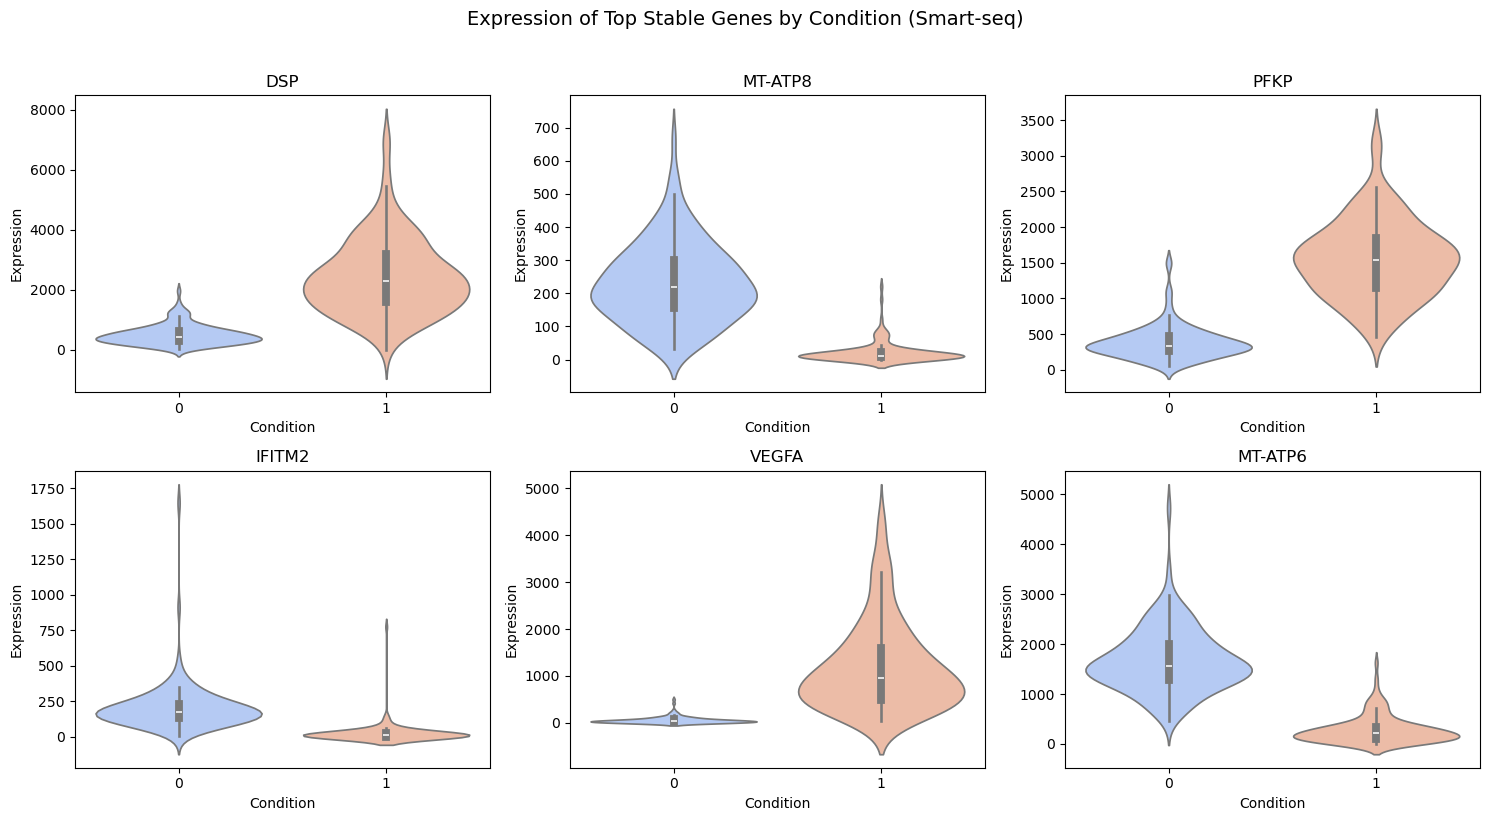

In [51]:
# Prepare merged DataFrame
Xs_vis = X_mcf_smart[stable_genes_smart].copy()
Xs_vis["Label"] = y_mcf_smart

# Choose top N genes to visualize
top_genes_smart = stable_genes_smart[:6]  # or sort by RF importance

# Plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
for i, gene in enumerate(top_genes_smart):
    ax = axes.flat[i]
    sns.violinplot(x="Label", y=gene, hue="Label", data=Xs_vis, ax=ax,
                   inner="box", palette="coolwarm", legend=False)
    ax.set_title(gene)
    ax.set_xlabel("Condition")
    ax.set_ylabel("Expression")

# Remove unused subplots if any
for j in range(i + 1, len(axes.flat)):
    fig.delaxes(axes.flat[j])

fig.suptitle("Expression of Top Stable Genes by Condition (Smart-seq)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Each violin plot shows the expression of a gene across the two conditions: **Normoxia (0)** and **Hypoxia (1)**. The inner boxplot indicates the interquartile range and median.

Several genes exhibit strong differential expression between the two conditions — for instance, some genes display clear shifts in expression levels, supporting their discriminative power. This validates their inclusion in the model and highlights their potential biological relevance in hypoxia response mechanisms.

The consistency of these patterns reinforces confidence in the robustness of the supervised model and the biological validity of the selected features.

### **5.2.** ***DropSeq***

#### **5.2.1.** Over - Representation Analysis

In [52]:
paths = {
    "MSigDB_Hallmark": "../Data/MSigDB_Hallmark.gmt",
    "GO_BP":  "../Data/GO_BP.gmt",
}

for name, p in paths.items():
    enr = gp.enrichr(
        gene_list=stable_genes_drop,
        gene_sets=p,          # point to one local GMT file
        organism='Human',
        outdir=None,
        cutoff=0.05
    )
    df_drop = enr.results.sort_values("Adjusted P-value")
    print(f"\n=== {name} ===")
    display(df_drop[['Term','Overlap','Adjusted P-value','Genes']].head(5))


=== MSigDB_Hallmark ===


,Term,Overlap,Adjusted P-value,Genes
6,HALLMARK_GLYCOLYSIS,4/200,0.005714,TPI1;PKM;PGK1;ENO1
7,HALLMARK_HYPOXIA,4/200,0.005714,GAPDH;TPI1;PGK1;ENO1
8,HALLMARK_MTORC1_SIGNALING,4/200,0.005714,GAPDH;TPI1;PGK1;ENO1
9,HALLMARK_MYC_TARGETS_V1,3/200,0.041696,RPL34;RPS5;PGK1
3,HALLMARK_ESTROGEN_RESPONSE_EARLY,2/200,0.185561,KRT19;TFF1



=== GO_BP ===


,Term,Overlap,Adjusted P-value,Genes
69,GOBP_CYTOPLASMIC_TRANSLATION,9/171,5.120977e-12,RPS19;RPL15;RPL13;RPS14;RPL12;RPS5;PKM;RPL34;R...
423,GOBP_TRANSLATION,10/753,5.084974e-08,RPS19;RPL15;RPL13;GAPDH;RPS14;RPL12;RPS5;PKM;R...
94,GOBP_GLYCOLYTIC_PROCESS_THROUGH_GLUCOSE_6_PHOS...,4/22,5.792350e-07,TPI1;PKM;PGK1;ENO1
93,GOBP_GLYCOLYTIC_PROCESS_THROUGH_FRUCTOSE_6_PHO...,4/26,8.858053e-07,TPI1;PKM;PGK1;ENO1
90,GOBP_GLUCOSE_CATABOLIC_PROCESS,4/30,1.296021e-06,TPI1;PKM;PGK1;ENO1


The enrichment results revealed a **strong and coherent biological signal**, with the most significant terms involving **glycolysis and related metabolic pathways**, all highly relevant to cellular adaptation to hypoxia.

These results validate that the genes identified through statistical and machine learning-based selection:

- Are **biologically coherent** and not arbitrarily selected.
- Reflect **hypoxia-driven metabolic rewiring**, consistent with the cell line context.
- Overlap meaningfully with key metabolic and stress-response pathways, just like in the Smart-seq dataset.


#### **5.2.2.** Comparison with Buffa's Signature

In [53]:
gene_names_in_dataset = set(stable_genes_drop)

# Convert BUFFA gene list to a set
buffa_set = set(buffa_genes)

# Compute intersection with your dataset
found_genes = list(buffa_set & gene_names_in_dataset)

print(f"Overlap of {len(found_genes)} genes between our selected genes and Buffa genes:")
print(sorted(found_genes))

Overlap of 4 genes between our selected genes and Buffa genes:
['ENO1', 'GAPDH', 'PGK1', 'TPI1']


#### **5.2.3.** Expression Patterns of Top Stable Genes
The violin plots below show the expression of the top 6 genes selected by the Drop-seq feature selection pipeline.

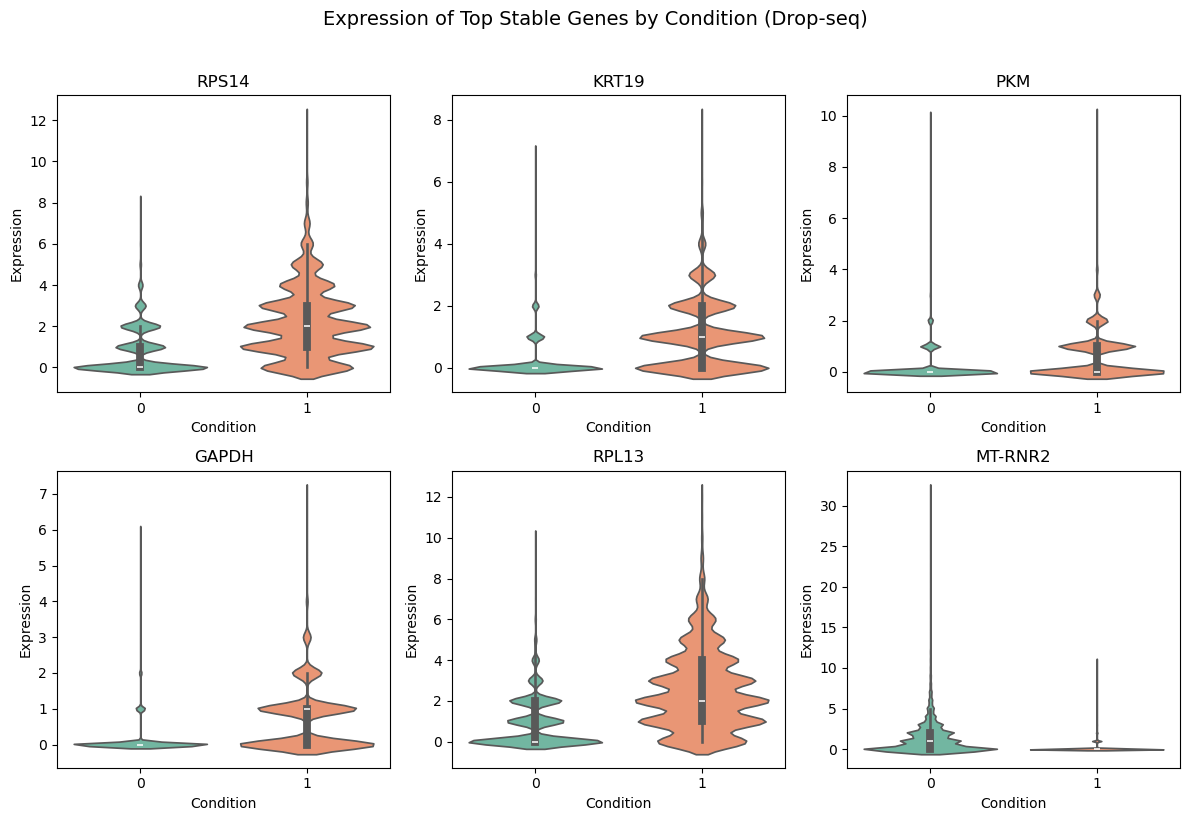

In [54]:
# Prepare merged DataFrame
Xd_vis = X_mcf_drop[stable_genes_drop].copy()
Xd_vis["Label"] = y_mcf_drop

# Choose top N genes to visualize
top_genes_drop = stable_genes_drop[:6]  # or sort by RF importance

# Plot
ncols = 3
nrows = -(-len(top_genes_drop) // ncols)  # ceiling division
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

for i, gene in enumerate(top_genes_drop):
    ax = axes.flat[i]
    sns.violinplot(x="Label", y=gene, hue="Label", data=Xd_vis,
                   ax=ax, inner="box", palette="Set2", legend=False)
    ax.set_title(gene)
    ax.set_xlabel("Condition")
    ax.set_ylabel("Expression")

# Remove any unused subplots
for j in range(i + 1, len(axes.flat)):
    fig.delaxes(axes.flat[j])

fig.suptitle("Expression of Top Stable Genes by Condition (Drop-seq)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Each violin plot visualizes the expression distribution of a top stable gene across the two conditions: **Normoxia (0)** and **Hypoxia (1)**. The shaded violins illustrate density, while the inner boxplots capture median and interquartile range.

These patterns align with the model’s feature selection and support the stability-based strategy used, highlighting genes with consistent and biologically interpretable shifts between conditions.


## **6.** Model Training and Evaluation
---

We benchmark five supervised classifiers on our final gene signature:

- **Logistic Regression**  
- **Support Vector Machine (SVM)**  
- **K‐Nearest Neighbors (KNN)**  
- **Multi‐Layer Perceptron (MLP)**  
- **XGBoost**

Each model is evaluated with **5-fold stratified cross-validation** on the training set, then assessed once on the held-out validation set.  Our evaluation criteria include:

- **ROC AUC** (discrimination capacity)  
  - ROC AUC remains valuable because it is threshold-independent and robust to class imbalance.  
- **Accuracy, Precision, Recall, F1 Score**  
  - Provide complementary views on overall correctness (Accuracy), positive-class focus (Precision), sensitivity (Recall), and their harmonic mean (F1).  
- **Confusion Matrix**  
  - Illustrates class-specific error patterns for deeper error analysis.

**Implementation details**  
- Models that are sensitive to feature scale (Logistic, SVM, KNN, MLP) are wrapped in a `Pipeline` with `StandardScaler()`.  
- Hyperparameters for each model are tuned via inner 5-fold `GridSearchCV` (scoring=`roc_auc`).  
- After cross-validation, the best hyperparameter setting is used to retrain each model on the full training set and then saved for downstream application.

This unified framework ensures a fair comparison across linear, distance-based, neural, and tree-based models, allowing us to select the classifier with the strongest and most reliable performance.  


### **6.1.** ***SmartSeq***

In [55]:

def evaluate_model(model, param_grid, X, y, name="Model", scale=False,
                   save=False, refit=True, save_path="Models_smart", cv_folds=5):

    print(f"\n Evaluating: {name}")

    # Build pipeline
    steps = []
    if scale:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", model))
    base_pipe = Pipeline(steps)

    # Hyperparameter tuning on full CV folds
    grid = GridSearchCV(base_pipe, param_grid, cv=cv_folds,
                        scoring="roc_auc", n_jobs=-1, verbose=1, refit=True)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    print(f" Best params: {grid.best_params_}")

    # Nested CV: outer CV for metrics, inner CV for tuning
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Cross-validated predictions
    y_pred = cross_val_predict(best_model, X, y, cv=skf)
    y_proba = cross_val_predict(best_model, X, y, cv=skf, method='predict_proba')[:, 1]

    # Metrics
    metrics = {
        "Model": name,
        "Best Params": grid.best_params_,
        "F1 Score": f1_score(y, y_pred),
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "ROC AUC": roc_auc_score(y, y_proba),
        "Confusion Matrix": confusion_matrix(y, y_pred)
    }

    # Display results
    for k, v in metrics.items():
        if k != "Confusion Matrix":
            if isinstance(v, (float, int)):
                print(f"{k:15}: {v:.4f}")
            else:
                print(f"{k:15}: {v}")
                
    # Refit and save the model
    suffix = "MCF"
    if refit:
        best_model.fit(X, y)
        if save:
            os.makedirs(save_path, exist_ok=True)
            filename = f"{name}.{suffix}.pkl"
            filepath = Path(save_path) / filename
            with open(filepath, "wb") as f:
                pickle.dump(best_model, f)
            print(f"Model saved to {filepath}")

    return best_model, metrics

In [56]:
# Define models and whether to scale
models = {
    "Logistic": LogisticRegression(solver="saga", max_iter=5000),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
}

param_grids = {
    "Logistic": {"clf__C": [0.01, 0.1, 1, 10]},
    "SVM":      {"clf__C": [0.1, 1, 10], "clf__kernel": ["linear", "rbf"]},
    "KNN":      {"clf__n_neighbors": [3, 5, 7, 9]},
    "MLP":      {"clf__hidden_layer_sizes": [(16,), (32,), (64,)], "clf__alpha": [1e-4, 1e-3]},
    "XGBoost":  {"clf__n_estimators": [50, 100, 200], "clf__max_depth": [3, 5, 7]}
}

results_smart = []
fitted_models = {}
for name, model in models.items():
    scale = name != "XGBoost"
    best_clf, metrics = evaluate_model(
        model=model,
        param_grid=param_grids[name],
        X=Xs_train_log[stable_genes_smart],  # or final_transferable_genes
        y=ys_train,
        name=name,
        scale=scale,
        save=True,
        refit=True,
        save_path="Models_smart",
        cv_folds=5
    )
    results_smart.append(metrics)
    fitted_models[name] = best_clf

# Display summary
dfs_results = pd.DataFrame(results_smart).drop(columns=["Confusion Matrix"])
print("\n Summary of All Model Results:")
def highlight_single_best(col):
    max_idx = col.values.argmax()
    return ['background-color: #7bc800' if i == max_idx else '' for i in range(len(col))]

styled = dfs_results.style.apply(
    highlight_single_best,
    subset=["F1 Score", "Accuracy", "Precision", "Recall", "ROC AUC"],
    axis=0  # apply column-wise
)

display(styled)


 Evaluating: Logistic
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__C': 0.01}
Model          : Logistic
Best Params    : {'clf__C': 0.01}
F1 Score       : 0.9950
Accuracy       : 0.9950
Precision      : 0.9900
Recall         : 1.0000
ROC AUC        : 1.0000
Model saved to Models_smart/Logistic.MCF.pkl

 Evaluating: SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
Model          : SVM
Best Params    : {'clf__C': 0.1, 'clf__kernel': 'linear'}
F1 Score       : 1.0000
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
ROC AUC        : 1.0000
Model saved to Models_smart/SVM.MCF.pkl

 Evaluating: KNN
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__n_neighbors': 3}
Model          : KNN
Best Params    : {'clf__n_neighbors': 3}
F1 Score       : 1.0000
Accuracy       : 1.0000
Precision      : 1.0000
Recall         : 1.0000
ROC AUC        

,Model,Best Params,F1 Score,Accuracy,Precision,Recall,ROC AUC
0,Logistic,{'clf__C': 0.01},0.994975,0.995000,0.990000,1.000000,1.000000
1,SVM,"{'clf__C': 0.1, 'clf__kernel': 'linear'}",1.000000,1.000000,1.000000,1.000000,1.000000
2,KNN,{'clf__n_neighbors': 3},1.000000,1.000000,1.000000,1.000000,1.000000
3,MLP,"{'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (16,)}",1.000000,1.000000,1.000000,1.000000,1.000000
4,XGBoost,"{'clf__max_depth': 3, 'clf__n_estimators': 50}",0.979798,0.980000,0.979798,0.979798,0.999000


In [57]:
print("\n\n--- Final Evaluation on Held-Out Validation Set ---")
for name, pipeline in fitted_models.items():
    print(f"\n{name}:")
    # pipeline includes scaler if needed
    X_val = Xs_val_log[stable_genes_smart]
    y_pred = pipeline.predict(X_val)
    y_proba = pipeline.predict_proba(X_val)[:, 1]

    print(f"F1 Score      : {f1_score(ys_val, y_pred):.4f}")
    print(f"Accuracy      : {accuracy_score(ys_val, y_pred):.4f}")
    print(f"Precision     : {precision_score(ys_val, y_pred):.4f}")
    print(f"Recall        : {recall_score(ys_val, y_pred):.4f}")
    print(f"ROC AUC       : {roc_auc_score(ys_val, y_proba):.4f}")
    print(f"Confusion Mat :\n{confusion_matrix(ys_val, y_pred)}")



--- Final Evaluation on Held-Out Validation Set ---

Logistic:
F1 Score      : 1.0000
Accuracy      : 1.0000
Precision     : 1.0000
Recall        : 1.0000
ROC AUC       : 1.0000
Confusion Mat :
[[25  0]
 [ 0 25]]

SVM:
F1 Score      : 0.9796
Accuracy      : 0.9800
Precision     : 1.0000
Recall        : 0.9600
ROC AUC       : 1.0000
Confusion Mat :
[[25  0]
 [ 1 24]]

KNN:
F1 Score      : 1.0000
Accuracy      : 1.0000
Precision     : 1.0000
Recall        : 1.0000
ROC AUC       : 1.0000
Confusion Mat :
[[25  0]
 [ 0 25]]

MLP:
F1 Score      : 0.9796
Accuracy      : 0.9800
Precision     : 1.0000
Recall        : 0.9600
ROC AUC       : 1.0000
Confusion Mat :
[[25  0]
 [ 1 24]]

XGBoost:
F1 Score      : 1.0000
Accuracy      : 1.0000
Precision     : 1.0000
Recall        : 1.0000
ROC AUC       : 1.0000
Confusion Mat :
[[25  0]
 [ 0 25]]


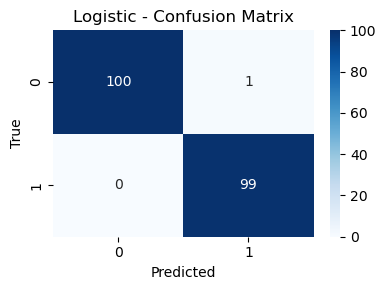

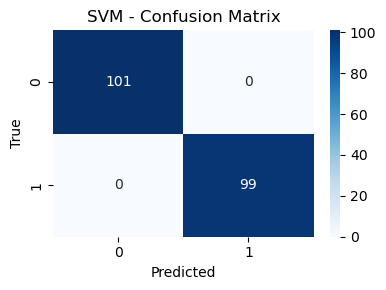

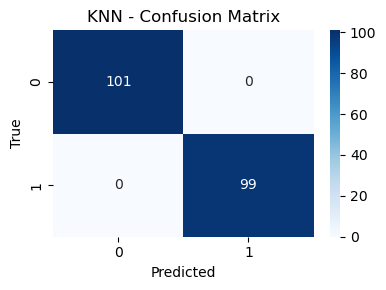

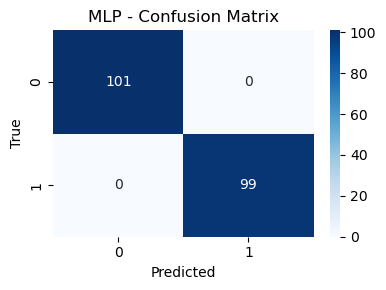

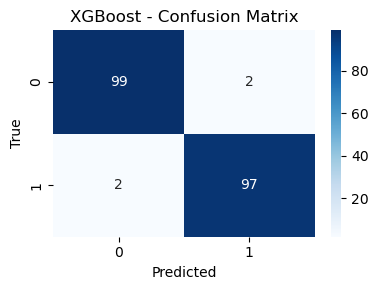

In [58]:
# Show confusion matrices after evaluation
for result in results_smart:
    cm = result["Confusion Matrix"]
    model_name = result["Model"]
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

#### - *Further Checks*
To ensure that this high accuracy did not result from overfitting or unintended data leakage, we performed two negative‐control experiments:

 - **Full Label Shuffling (Permutation Test)**:
  We permuted the training labels at random—i.e. replaced the true hypoxia/normoxia assignments with a randomly shuffled version—and reran 5-fold cross‐validation. If our model were simply memorizing idiosyncratic patterns in the features (rather than learning a genuine gene–label relationship), it would still achieve high AUC even on random labels.

In [59]:
# 1. Shuffle the labels
y_shuffled = np.random.permutation(ys_train)

# 2. Evaluate on shuffled labels (no save, no refit)
shuffled_clf, shuffled_metrics = evaluate_model(
    model=LogisticRegression(solver="saga", max_iter=5000),
    param_grid=param_grids["Logistic"],            # your Logistic grid
    X=Xs_train_log[stable_genes_smart],
    y=y_shuffled,
    name="Shuffled_Logistic",
    scale=True,
    refit=False,
    save=False,
    save_path="Models_smart",
    cv_folds=5
)


 Evaluating: Shuffled_Logistic
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__C': 0.01}
Model          : Shuffled_Logistic
Best Params    : {'clf__C': 0.01}
F1 Score       : 0.4916
Accuracy       : 0.5450
Precision      : 0.5500
Recall         : 0.4444
ROC AUC        : 0.5492


 - **Partial Label Corruption (Flip 10% and 30%)**. We next randomly flipped 10% of the training labels and re-evaluated the classifier.  
 We observed a marked drop in AUC and F1 once only 10% of labels were corrupted, and a further collapse when 30% were flipped. This graded degradation confirms that the model is genuinely fitting to the underlying biology (hypoxic gene‐expression patterns) rather than spurious noise.

In [60]:
def flip_labels(y, fraction=0.1, seed=42):
    np.random.seed(seed)
    y_flipped = y.copy()
    n_flip = int(len(y) * fraction)
    indices = np.random.choice(len(y), size=n_flip, replace=False)
    y_flipped[indices] = 1 - y_flipped[indices]  
    return y_flipped

# Flip 10% of ys_train
ys_train_flipped = flip_labels(ys_train, fraction=0.1)

# Evaluate performance again with flipped labels
model = LogisticRegression(max_iter=5000)

print("\nPerformance with 10% label corruption:")
clf_flipped, metrics_flipped = evaluate_model(
    model=model,
    param_grid=param_grids["Logistic"],
    X=Xs_train_log[stable_genes_smart],
    y=ys_train_flipped,
    name="Logistic_Flipped",
    scale=True,
    save=False,
    refit=False
)


Performance with 10% label corruption:

 Evaluating: Logistic_Flipped
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__C': 0.01}
Model          : Logistic_Flipped
Best Params    : {'clf__C': 0.01}
F1 Score       : 0.8945
Accuracy       : 0.8950
Precision      : 0.8900
Recall         : 0.8990
ROC AUC        : 0.9218


In [61]:
ys_train_flipped_30 = flip_labels(ys_train, fraction=0.3)
clf30, metrics30 = evaluate_model(
    model=LogisticRegression(max_iter=5000),
    param_grid=param_grids["Logistic"],
    X=Xs_train_log[stable_genes_smart],
    y=ys_train_flipped_30,
    name="Logistic_Flipped_30",
    scale=True,
    save=False,
    refit=False
)


 Evaluating: Logistic_Flipped_30
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__C': 0.01}
Model          : Logistic_Flipped_30
Best Params    : {'clf__C': 0.01}
F1 Score       : 0.7030
Accuracy       : 0.7000
Precision      : 0.7030
Recall         : 0.7030
ROC AUC        : 0.7093


In [62]:
del result  # avoid conflict with next loop

### **6.2.** ***DropSeq***

In [63]:

def evaluate_model_drop(model, param_grid, X, y, name="Model", scale=False,
                   save=False, refit=True, save_path="Models_drop", cv_folds=5):

    print(f"\n Evaluating: {name}")

    # Build pipeline
    steps = []
    if scale:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", model))
    base_pipe = Pipeline(steps)

    # Hyperparameter tuning on full CV folds
    grid = GridSearchCV(base_pipe, param_grid, cv=cv_folds,
                        scoring="roc_auc", n_jobs=-1, verbose=1, refit=True)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    print(f" Best params: {grid.best_params_}")

    # Nested CV: outer CV for metrics, inner CV for tuning
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Cross-validated predictions
    y_pred = cross_val_predict(best_model, X, y, cv=skf)
    y_proba = cross_val_predict(best_model, X, y, cv=skf, method='predict_proba')[:, 1]

    # Metrics
    metrics = {
        "Model": name,
        "Best Params": grid.best_params_,
        "F1 Score": f1_score(y, y_pred),
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "ROC AUC": roc_auc_score(y, y_proba),
        "Confusion Matrix": confusion_matrix(y, y_pred)
    }

    # Display results
    for k, v in metrics.items():
        if k != "Confusion Matrix":
            if isinstance(v, (float, int)):
                print(f"{k:15}: {v:.4f}")
            else:
                print(f"{k:15}: {v}")
                
    # Refit and save the model
    suffix = "MCF"
    if refit:
        best_model.fit(X, y)
        if save:
            os.makedirs(save_path, exist_ok=True)
            filename = f"{name}.{suffix}.pkl"
            filepath = Path(save_path) / filename
            with open(filepath, "wb") as f:
                pickle.dump(best_model, f)
            print(f"Model saved to {filepath}")

    return best_model, metrics

In [64]:
# Define models and whether to scale
models = {
    "Logistic": LogisticRegression(solver="saga", max_iter=5000),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
}

param_grids = {
    "Logistic": {"clf__C": [0.01, 0.1, 1, 10]},
    "SVM":      {"clf__C": [0.1, 1, 10], "clf__kernel": ["linear", "rbf"]},
    "KNN":      {"clf__n_neighbors": [3, 5, 7, 9]},
    "MLP":      {"clf__hidden_layer_sizes": [(16,), (32,), (64,)], "clf__alpha": [1e-4, 1e-3]},
    "XGBoost":  {"clf__n_estimators": [50, 100, 200], "clf__max_depth": [3, 5, 7]}
}

results_drop = []
fitted_models_drop = {}
for name, model in models.items():
    scale = name != "XGBoost"
    best_clf, metrics = evaluate_model_drop(
        model=model,
        param_grid=param_grids[name],
        X=Xd_train_log[stable_genes_drop],  # or final_transferable_genes
        y=yd_train,
        name=name,
        scale=scale,
        save=True,
        refit=True,
        save_path="Models_drop",
        cv_folds=5
    )
    results_drop.append(metrics)
    fitted_models_drop[name] = best_clf

# Display summary
dfd_results = pd.DataFrame(results_drop).drop(columns=["Confusion Matrix"])
print("\n Summary of All Model Results:")

styled = dfd_results.style.apply(
    highlight_single_best,
    subset=["F1 Score", "Accuracy", "Precision", "Recall", "ROC AUC"],
    axis=0  # apply column-wise
)

display(styled)


 Evaluating: Logistic
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__C': 10}
Model          : Logistic
Best Params    : {'clf__C': 10}
F1 Score       : 0.9410
Accuracy       : 0.9518
Precision      : 0.9509
Recall         : 0.9313
ROC AUC        : 0.9871
Model saved to Models_drop/Logistic.MCF.pkl

 Evaluating: SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best params: {'clf__C': 1, 'clf__kernel': 'rbf'}
Model          : SVM
Best Params    : {'clf__C': 1, 'clf__kernel': 'rbf'}
F1 Score       : 0.9454
Accuracy       : 0.9558
Precision      : 0.9628
Recall         : 0.9287
ROC AUC        : 0.9892
Model saved to Models_drop/SVM.MCF.pkl

 Evaluating: KNN
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 Best params: {'clf__n_neighbors': 9}
Model          : KNN
Best Params    : {'clf__n_neighbors': 9}
F1 Score       : 0.9255
Accuracy       : 0.9414
Precision      : 0.9744
Recall         : 0.8812
ROC AUC        : 0.9775
Model s

,Model,Best Params,F1 Score,Accuracy,Precision,Recall,ROC AUC
0,Logistic,{'clf__C': 10},0.941027,0.951850,0.950923,0.931334,0.987052
1,SVM,"{'clf__C': 1, 'clf__kernel': 'rbf'}",0.945431,0.955780,0.962807,0.928672,0.989245
2,KNN,{'clf__n_neighbors': 9},0.925454,0.941445,0.974430,0.881166,0.977520
3,MLP,"{'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (16,)}",0.943565,0.954046,0.956121,0.931334,0.988899
4,XGBoost,"{'clf__max_depth': 3, 'clf__n_estimators': 200}",0.947019,0.956647,0.954843,0.939322,0.990246


In [65]:
print("\n\n--- Final Evaluation on Held-Out Validation Set ---")
for name, pipeline in fitted_models_drop.items():
    print(f"\n{name}:")
    # pipeline includes scaler if needed
    X_val = Xd_val_log[stable_genes_drop]
    y_pred = pipeline.predict(X_val)
    y_proba = pipeline.predict_proba(X_val)[:, 1]

    print(f"F1 Score      : {f1_score(yd_val, y_pred):.4f}")
    print(f"Accuracy      : {accuracy_score(yd_val, y_pred):.4f}")
    print(f"Precision     : {precision_score(yd_val, y_pred):.4f}")
    print(f"Recall        : {recall_score(yd_val, y_pred):.4f}")
    print(f"ROC AUC       : {roc_auc_score(yd_val, y_proba):.4f}")
    print(f"Confusion Mat :\n{confusion_matrix(yd_val, y_pred)}")



--- Final Evaluation on Held-Out Validation Set ---

Logistic:
F1 Score      : 0.9428
Accuracy      : 0.9531
Precision     : 0.9479
Recall        : 0.9378
ROC AUC       : 0.9864
Confusion Mat :
[[2449   92]
 [ 111 1674]]

SVM:
F1 Score      : 0.9449
Accuracy      : 0.9552
Precision     : 0.9590
Recall        : 0.9311
ROC AUC       : 0.9877
Confusion Mat :
[[2470   71]
 [ 123 1662]]

KNN:
F1 Score      : 0.9274
Accuracy      : 0.9427
Precision     : 0.9718
Recall        : 0.8868
ROC AUC       : 0.9781
Confusion Mat :
[[2495   46]
 [ 202 1583]]

MLP:
F1 Score      : 0.9472
Accuracy      : 0.9568
Precision     : 0.9540
Recall        : 0.9406
ROC AUC       : 0.9885
Confusion Mat :
[[2460   81]
 [ 106 1679]]

XGBoost:
F1 Score      : 0.9453
Accuracy      : 0.9552
Precision     : 0.9522
Recall        : 0.9384
ROC AUC       : 0.9886
Confusion Mat :
[[2457   84]
 [ 110 1675]]


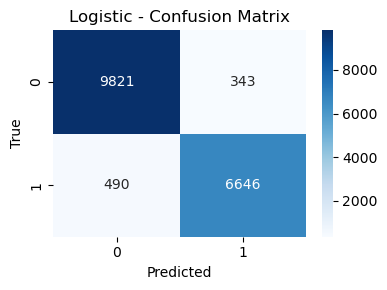

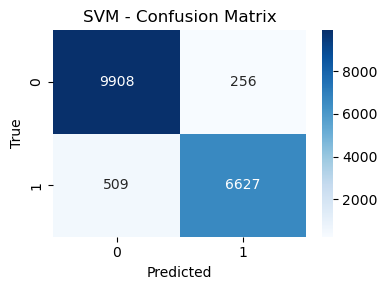

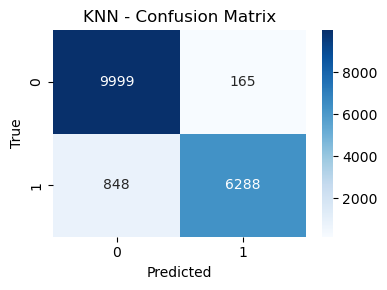

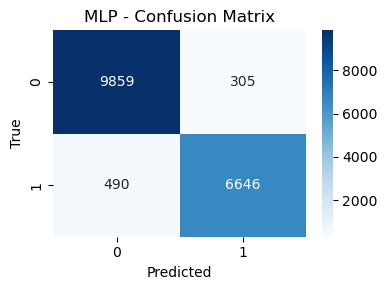

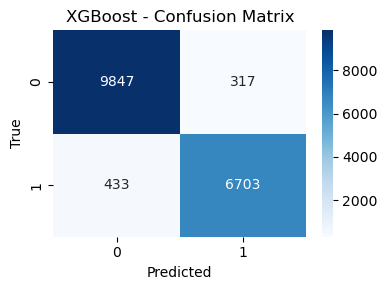

In [66]:
# Show confusion matrices after evaluation
for result in results_drop:
    cm = result["Confusion Matrix"]
    model_name = result["Model"]
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

#### - *Further Checks*

In [67]:
# 1. Shuffle the labels
y_shuffled_drop = np.random.permutation(yd_train)

# 2. Evaluate on shuffled labels (no save, no refit)
shuffled_clf, shuffled_metrics = evaluate_model_drop(
    model= XGBClassifier(eval_metric='logloss'),
    param_grid=param_grids["XGBoost"],            
    X=Xd_train_log[stable_genes_drop],
    y=y_shuffled_drop,
    name="Shuffled_XGBoost",
    scale=True,
    refit=False,
    save=False,
    save_path="Models_drop",
    cv_folds=5
)


 Evaluating: Shuffled_XGBoost
Fitting 5 folds for each of 9 candidates, totalling 45 fits
 Best params: {'clf__max_depth': 7, 'clf__n_estimators': 100}
Model          : Shuffled_XGBoost
Best Params    : {'clf__max_depth': 7, 'clf__n_estimators': 100}
F1 Score       : 0.2697
Accuracy       : 0.5483
Precision      : 0.4048
Recall         : 0.2022
ROC AUC        : 0.4956


In [68]:
yd_train_flipped = flip_labels(yd_train, fraction=0.1)

# Evaluate performance again with flipped labels
model = XGBClassifier(eval_metric='logloss')

print("\nPerformance with 10% label corruption:")
clf_flipped, metrics_flipped = evaluate_model_drop(
    model=model,
    param_grid=param_grids["XGBoost"],
    X=Xd_train_log[stable_genes_drop],
    y=yd_train_flipped,
    name="XGBoost_Flipped",
    scale=True,
    save=False,
    refit=False
)


Performance with 10% label corruption:

 Evaluating: XGBoost_Flipped
Fitting 5 folds for each of 9 candidates, totalling 45 fits
 Best params: {'clf__max_depth': 3, 'clf__n_estimators': 100}
Model          : XGBoost_Flipped
Best Params    : {'clf__max_depth': 3, 'clf__n_estimators': 100}
F1 Score       : 0.8320
Accuracy       : 0.8615
Precision      : 0.8604
Recall         : 0.8055
ROC AUC        : 0.8842


In [69]:
yd_train_flipped_30 = flip_labels(yd_train, fraction=0.3)
clf30, metrics30 = evaluate_model_drop(
    model=XGBClassifier(eval_metric='logloss'),
    param_grid=param_grids["XGBoost"],
    X=Xd_train_log[stable_genes_drop],
    y=yd_train_flipped_30,
    name="XGBoost_Flipped_30",
    scale=True,
    save=False,
    refit=False
)


 Evaluating: XGBoost_Flipped_30
Fitting 5 folds for each of 9 candidates, totalling 45 fits
 Best params: {'clf__max_depth': 3, 'clf__n_estimators': 50}
Model          : XGBoost_Flipped_30
Best Params    : {'clf__max_depth': 3, 'clf__n_estimators': 50}
F1 Score       : 0.6169
Accuracy       : 0.6717
Precision      : 0.6701
Recall         : 0.5716
ROC AUC        : 0.6875
